In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import skimage.measure
from pathlib import Path
import os

## 1. Load NPZ File

In [ ]:
# Path to NPZ files
data_dir = "[path to mesh folder: mesh_minimal_scaled_obj_files]"

# List available NPZ files
npz_files = sorted(list(Path(data_dir).glob("*.npz")))
print(f"Found {len(npz_files)} NPZ files")
print("\nFirst 5 files:")
for i, f in enumerate(npz_files[:5]):
    print(f"{i}: {f.name}")

In [ ]:
# Load a sample file
sample_idx = 0  # Change this to load different files
npz_file = npz_files[sample_idx]

print(f"Loading: {npz_file.name}")
data = np.load(npz_file)

# Show what's in the NPZ file
print(f"\nKeys in NPZ file: {list(data.keys())}")
for key in data.keys():
    print(f"  {key}: shape {data[key].shape}, dtype {data[key].dtype}")

## 2. Extract XYZ Coordinates and SDF Values

In [ ]:
# Extract positive and negative samples
# Typically: 'pos' = points with positive SDF (outside), 'neg' = points with negative SDF (inside/near surface)

if 'pos' in data and 'neg' in data:
    # Standard DeepSDF format
    pos_samples = data['pos']  # [N, 4] - xyz + sdf
    neg_samples = data['neg']  # [M, 4] - xyz + sdf
    
    # Combine all samples
    all_samples = np.vstack([pos_samples, neg_samples])
    
    print(f"Positive samples: {pos_samples.shape[0]}")
    print(f"Negative samples: {neg_samples.shape[0]}")
    print(f"Total samples: {all_samples.shape[0]}")
    
elif 'data' in data:
    # Alternative format
    all_samples = data['data']
    print(f"Total samples: {all_samples.shape[0]}")
else:
    # Generic: try to find the main array
    all_samples = data[list(data.keys())[0]]
    print(f"Total samples: {all_samples.shape[0]}")

# Extract xyz and sdf
xyz = all_samples[:, :3]
sdf = all_samples[:, 3]

print(f"\nXYZ range: [{xyz.min():.3f}, {xyz.max():.3f}]")
print(f"SDF range: [{sdf.min():.3f}, {sdf.max():.3f}]")
print(f"Near-surface points (|SDF| < 0.01): {np.sum(np.abs(sdf) < 0.01)}")

## 3. Visualize Point Cloud with SDF Values

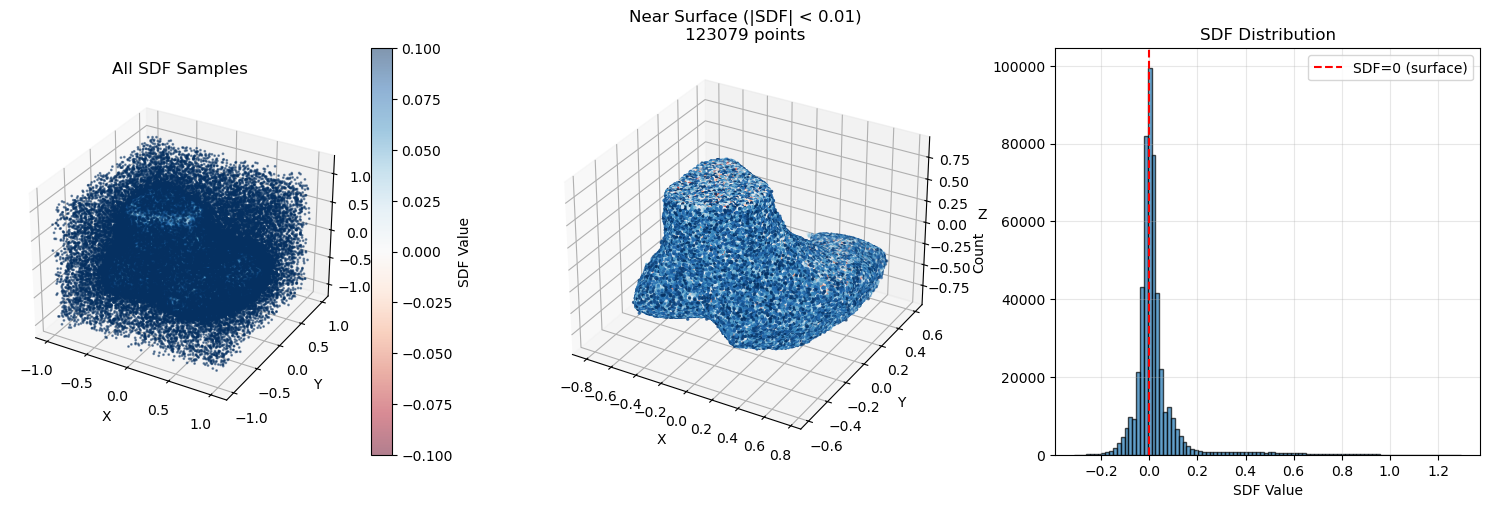

In [7]:
# Visualize points colored by SDF value
fig = plt.figure(figsize=(15, 5))

# Plot 1: All points colored by SDF
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 
                     c=sdf, cmap='RdBu', s=1, alpha=0.5, vmin=-0.1, vmax=0.1)
ax1.set_title('All SDF Samples')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
plt.colorbar(scatter, ax=ax1, label='SDF Value')

# Plot 2: Near-surface points only
ax2 = fig.add_subplot(132, projection='3d')
near_surface = np.abs(sdf) < 0.01
ax2.scatter(xyz[near_surface, 0], xyz[near_surface, 1], xyz[near_surface, 2], 
           c=sdf[near_surface], cmap='RdBu', s=2, vmin=-0.01, vmax=0.01)
ax2.set_title(f'Near Surface (|SDF| < 0.01)\n{near_surface.sum()} points')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Plot 3: SDF histogram
ax3 = fig.add_subplot(133)
ax3.hist(sdf, bins=100, alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', label='SDF=0 (surface)')
ax3.set_xlabel('SDF Value')
ax3.set_ylabel('Count')
ax3.set_title('SDF Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Create Mesh from SDF Points Using Marching Cubes

In [8]:
def create_mesh_from_sdf_points(xyz, sdf, resolution=128, smooth_iterations=5):
    """
    Create SMOOTH mesh from scattered SDF points using marching cubes.
    
    Steps:
    1. Create regular 3D grid
    2. Interpolate SDF values onto grid with LINEAR interpolation
    3. Apply marching cubes to extract isosurface
    4. Apply strong Laplacian smoothing for smooth surface
    """
    from scipy.interpolate import griddata
    
    # Determine bounds
    min_bound = xyz.min(axis=0)
    max_bound = xyz.max(axis=0)
    
    print(f"Bounds: [{min_bound}, {max_bound}]")
    
    # Create regular grid
    x = np.linspace(min_bound[0], max_bound[0], resolution)
    y = np.linspace(min_bound[1], max_bound[1], resolution)
    z = np.linspace(min_bound[2], max_bound[2], resolution)
    
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1)
    
    print(f"Created {resolution}³ grid = {grid_points.shape[0]} points")
    print("Interpolating SDF values onto grid with LINEAR method...")
    
    # Use LINEAR interpolation for smooth surfaces
    grid_sdf = griddata(xyz, sdf, grid_points, method='linear', fill_value=1.0)
    grid_sdf = grid_sdf.reshape(resolution, resolution, resolution)
    
    print(f"Grid SDF range: [{grid_sdf.min():.3f}, {grid_sdf.max():.3f}]")
    
    # Apply marching cubes
    print("Running marching cubes...")
    voxel_size = (max_bound - min_bound).max() / (resolution - 1)
    
    try:
        verts, faces, normals, values = skimage.measure.marching_cubes(
            grid_sdf, 
            level=0.0,  # Extract zero isosurface
            spacing=[voxel_size] * 3,
            method='lewiner'
        )
        
        # Adjust vertices to actual coordinates
        verts = verts + min_bound
        
        print(f"\nInitial mesh:")
        print(f"  Vertices: {verts.shape[0]}")
        print(f"  Faces: {faces.shape[0]}")
        
        # Create trimesh object
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
        
        # Apply STRONG Laplacian smoothing
        print(f"\nApplying Laplacian smoothing ({smooth_iterations} iterations)...")
        for i in range(smooth_iterations):
            trimesh.smoothing.filter_laplacian(mesh, lamb=0.3, iterations=1)
            if (i + 1) % 3 == 0:
                print(f"  Completed {i+1}/{smooth_iterations} iterations...")
        
        print("✓ Smoothing complete!")
        print(f"\nFinal mesh:")
        print(f"  Vertices: {len(mesh.vertices)}")
        print(f"  Faces: {len(mesh.faces)}")
        
        return mesh
        
    except Exception as e:
        print(f"Error during marching cubes: {e}")
        return None

In [ ]:
# Create mesh with different resolutions
# Start with lower resolution for speed
resolution = 64  # Try 64, 128, or 256

mesh = create_mesh_from_sdf_points(xyz, sdf, resolution=resolution)

## 5. Visualize the Reconstructed Mesh

Mesh Statistics:
  Vertices: 8376
  Faces: 16748
  Watertight: True
  Volume: 1.1587
  Surface Area: 7.0788
  Bounds: [[-0.72180539 -0.52388189 -0.83264897]
 [ 0.90351144  0.75430842  0.84513062]]


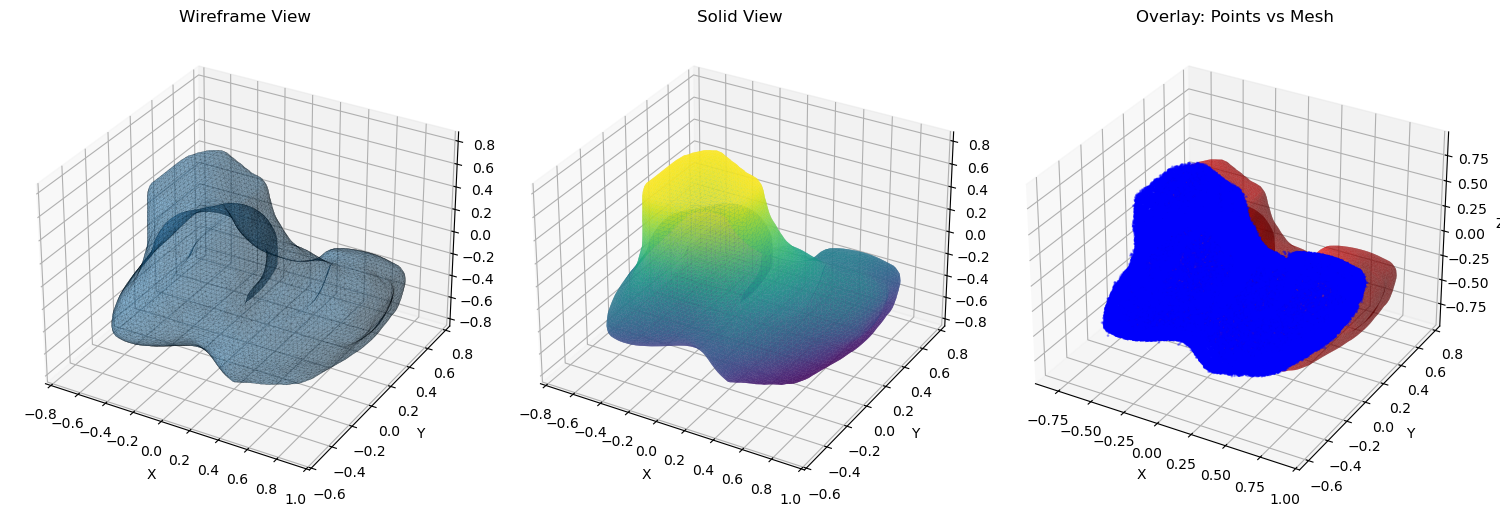

In [11]:
if mesh is not None:
    # Display mesh info
    print("Mesh Statistics:")
    print(f"  Vertices: {len(mesh.vertices)}")
    print(f"  Faces: {len(mesh.faces)}")
    print(f"  Watertight: {mesh.is_watertight}")
    print(f"  Volume: {mesh.volume:.4f}")
    print(f"  Surface Area: {mesh.area:.4f}")
    print(f"  Bounds: {mesh.bounds}")
    
    # Plot mesh
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Wireframe
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], 
                     mesh.vertices[:, 2], triangles=mesh.faces,
                     alpha=0.3, edgecolor='black', linewidth=0.1)
    ax1.set_title('Wireframe View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Plot 2: Solid mesh
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], 
                     mesh.vertices[:, 2], triangles=mesh.faces,
                     cmap='viridis', alpha=0.8)
    ax2.set_title('Solid View')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Plot 3: Compare with original points
    ax3 = fig.add_subplot(133, projection='3d')
    near_surface = np.abs(sdf) < 0.01
    ax3.scatter(xyz[near_surface, 0], xyz[near_surface, 1], xyz[near_surface, 2],
               c='blue', s=1, alpha=0.3, label='Original SDF points')
    ax3.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], 
                     mesh.vertices[:, 2], triangles=mesh.faces,
                     alpha=0.5, color='red', label='Reconstructed mesh')
    ax3.set_title('Overlay: Points vs Mesh')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()
else:
    print("Failed to create mesh")

## 6. Save Mesh to PLY File

In [ ]:
if mesh is not None:
    # Create output directory
    output_dir = "examples/CALSNIC_control_L_local/Reconstructions"
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate output filename based on input NPZ file
    output_filename = f"{npz_file.stem}_reconstructed_res{resolution}.ply"
    output_path = os.path.join(output_dir, output_filename)
    
    # Save mesh as PLY file
    mesh.export(output_path)
    
    print(f"✓ Mesh saved successfully!")
    print(f"  File: {output_path}")
    print(f"  Format: PLY")
    print(f"  Size: {os.path.getsize(output_path) / 1024:.2f} KB")
    print(f"\nYou can open this file in:")
    print("  - MeshLab")
    print("  - Blender")
    print("  - CloudCompare")
    print("  - Any 3D viewer that supports PLY format")
else:
    print("No mesh available to save")